# Analysis of Crime Data in Cuyahoga County

In [1]:
import requests
import json
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from citipy import citipy
import numpy as np
from scipy.stats import linregress
import gmaps

from api_keys import weather_api_key
from api_keys import fbi_key
from api_keys import g_key


In [2]:
crime_2017 = pd.read_csv("ocjs_crimebycounty2017.csv")
crime_2017.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OH02538,OHIO DEPT OF NATURAL RESOURCES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OHOHP00,OHIO STATE HGHWAY PATROL,NaN,280,209,3.0,42,6,229,3,157,49,4
2,NaN,TOTAL,NaN,280,209,3.0,42,6,229,3,157,49,4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OH00102,PEEBLES,"1,746",3,3,NaN,NaN,NaN,3,1,1,1,NaN


In [3]:
cuy_crime=crime_2017.loc[153:199, :].reset_index(drop=True)
cuy_crime.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OHCLP00,CLEVELAND,"385,351","5,999","18,944",107.0,497,"2,697","2,698","5,853","9,696","3,395",253
1,OH018A1,NOTRE DAME COLLEGE,NaN,2,38,NaN,2,NaN,NaN,9,29,NaN,NaN
2,OH01801,BAY VILLAGE,"15,327",2,73,NaN,1,NaN,1,11,61,1,NaN
3,OH01803,BEDFORD,"12,641",25,228,1.0,1,16,7,50,146,32,NaN
4,OH01804,BEDFORD HEIGHTS,"10,558",22,255,1.0,1,9,11,32,173,50,NaN


In [4]:
cuy_crime_null=cuy_crime.fillna(0)
cuy_crime_null.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OHCLP00,CLEVELAND,"385,351","5,999","18,944",107.0,497,"2,697","2,698","5,853","9,696","3,395",253
1,OH018A1,NOTRE DAME COLLEGE,0,2,38,0.0,2,0,0,9,29,0,0
2,OH01801,BAY VILLAGE,"15,327",2,73,0.0,1,0,1,11,61,1,0
3,OH01803,BEDFORD,"12,641",25,228,1.0,1,16,7,50,146,32,0
4,OH01804,BEDFORD HEIGHTS,"10,558",22,255,1.0,1,9,11,32,173,50,0


In [5]:
cuy_data=cuy_crime_null.drop(cuy_crime_null[cuy_crime_null["POPULATION"]==0].index).reset_index(drop=True)
cuy_data.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OHCLP00,CLEVELAND,"385,351","5,999","18,944",107.0,497,"2,697","2,698","5,853","9,696","3,395",253
1,OH01801,BAY VILLAGE,"15,327",2,73,0.0,1,0,1,11,61,1,0
2,OH01803,BEDFORD,"12,641",25,228,1.0,1,16,7,50,146,32,0
3,OH01804,BEDFORD HEIGHTS,"10,558",22,255,1.0,1,9,11,32,173,50,0
4,OH01806,BEREA,"18,871",8,140,0.0,1,1,6,27,105,8,2


In [6]:
#Summary of cuy_data_df. This shows that the Population and crime categories are typed as objects, except for "Murder"
cuy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ORI                 42 non-null     object 
 1   AGENCY NAME         42 non-null     object 
 2   POPULATION          42 non-null     object 
 3   VIOLENT CRIME       42 non-null     object 
 4   PROPERTY CRIME      42 non-null     object 
 5   MURDER              42 non-null     float64
 6   RAPE                42 non-null     object 
 7   ROBBERY             42 non-null     object 
 8   AGGRAVATED ASSAULT  42 non-null     object 
 9   BURGLARY            42 non-null     object 
 10  LARCENY             42 non-null     object 
 11  MTR VEHICLE THEFT   42 non-null     object 
 12  ARSON               42 non-null     object 
dtypes: float64(1), object(12)
memory usage: 4.4+ KB


In [7]:
#Remove commas from numerical values to be able to change values to integers
#df.replace(',','', regex=True, inplace=True)
cuy_data.replace(',','', regex=True, inplace=True)
cuy_data.head()


#Change Population & Crime categories from object to numeric values using pd.to_numeric(s, errors='coerce')
cuy_data["POPULATION"]=pd.to_numeric(cuy_data["POPULATION"])
cuy_data["VIOLENT CRIME"]=pd.to_numeric(cuy_data["VIOLENT CRIME"])
cuy_data["PROPERTY CRIME"]=pd.to_numeric(cuy_data["PROPERTY CRIME"])
cuy_data["MURDER"]=pd.to_numeric(cuy_data["MURDER"])
cuy_data["RAPE"]=pd.to_numeric(cuy_data["RAPE"])
cuy_data["ROBBERY"]=pd.to_numeric(cuy_data["ROBBERY"])
cuy_data["AGGRAVATED ASSAULT"]=pd.to_numeric(cuy_data["AGGRAVATED ASSAULT"])
cuy_data["BURGLARY"]=pd.to_numeric(cuy_data["BURGLARY"])
cuy_data["LARCENY"]=pd.to_numeric(cuy_data["LARCENY"])
cuy_data["MTR VEHICLE THEFT"]=pd.to_numeric(cuy_data["MTR VEHICLE THEFT"])
cuy_data["ARSON"]=pd.to_numeric(cuy_data["ARSON"])

#Summary of cuy_data_df to check that the values now show as numeric, either integer or float
cuy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ORI                 42 non-null     object 
 1   AGENCY NAME         42 non-null     object 
 2   POPULATION          42 non-null     int64  
 3   VIOLENT CRIME       42 non-null     int64  
 4   PROPERTY CRIME      42 non-null     int64  
 5   MURDER              42 non-null     float64
 6   RAPE                42 non-null     int64  
 7   ROBBERY             42 non-null     int64  
 8   AGGRAVATED ASSAULT  42 non-null     int64  
 9   BURGLARY            42 non-null     int64  
 10  LARCENY             42 non-null     int64  
 11  MTR VEHICLE THEFT   42 non-null     int64  
 12  ARSON               42 non-null     int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 4.4+ KB


In [8]:
#Drop the Population column from the sum shown in Totals column but keep the Population Column in the dataframe.
cuy_data['TOTALS'] = cuy_data.drop('POPULATION', axis=1).sum(axis=1)
cuy_data.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON,TOTALS
0,OHCLP00,CLEVELAND,385351,5999,18944,107.0,497,2697,2698,5853,9696,3395,253,50139.0
1,OH01801,BAY VILLAGE,15327,2,73,0.0,1,0,1,11,61,1,0,150.0
2,OH01803,BEDFORD,12641,25,228,1.0,1,16,7,50,146,32,0,506.0
3,OH01804,BEDFORD HEIGHTS,10558,22,255,1.0,1,9,11,32,173,50,0,554.0
4,OH01806,BEREA,18871,8,140,0.0,1,1,6,27,105,8,2,298.0


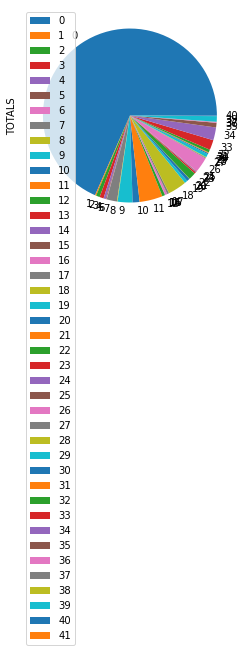

In [9]:
#Pie chart of totals
plot = cuy_data.plot.pie(y='TOTALS')

In [11]:
cuy_data.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON,TOTALS
0,OHCLP00,CLEVELAND,385351,5999,18944,107.0,497,2697,2698,5853,9696,3395,253,50139.0
1,OH01801,BAY VILLAGE,15327,2,73,0.0,1,0,1,11,61,1,0,150.0
2,OH01803,BEDFORD,12641,25,228,1.0,1,16,7,50,146,32,0,506.0
3,OH01804,BEDFORD HEIGHTS,10558,22,255,1.0,1,9,11,32,173,50,0,554.0
4,OH01806,BEREA,18871,8,140,0.0,1,1,6,27,105,8,2,298.0


In [13]:
#Use .loc for the index 
pop_cuy_data=index_cuy_data.loc[["CLEVELAND", "PARMA", "LAKEWOOD", "EUCLID", "STRONGSVILLE", "CLEVELAND HEIGHTS", "WESTLAKE", "BROOKLYN"]]
pop_cuy_data

,ORI,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON,TOTALS
AGENCY NAME,,,,,,,,,,,,,
CLEVELAND,OHCLP00,385351,5999,18944,107.0,497,2697,2698,5853,9696,3395,253,50139.0
PARMA,OH01842,79340,141,906,0.0,39,37,65,199,633,74,2,2096.0
LAKEWOOD,OH01826,50151,74,1199,2.0,6,40,26,469,652,78,5,2551.0
EUCLID,OH01818,47270,303,1267,4.0,26,118,155,226,910,131,6,3146.0
STRONGSVILLE,OH01851,44758,18,852,2.0,1,9,6,67,760,25,0,1740.0
CLEVELAND HEIGHTS,OH01815,44525,131,879,2.0,16,79,34,125,655,99,1,2021.0
WESTLAKE,OH01857,32330,13,366,0.0,1,9,3,25,326,15,0,758.0
BROOKLYN,OH01810,10809,23,677,1.0,5,11,6,31,612,34,0,1400.0


In [48]:
#Use .loc for the index 
suburb_cuy_data=index_cuy_data.loc[["PARMA", "LAKEWOOD", "EUCLID", "STRONGSVILLE", "CLEVELAND HEIGHTS", "WESTLAKE"]]
suburb_cuy_data.head(1)

,ORI,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON,TOTALS
AGENCY NAME,,,,,,,,,,,,,
PARMA,OH01842,79340,141,906,0.0,39,37,65,199,633,74,2,2096.0


In [44]:
#df.sum(axis = 0, skipna = True) 
suburb_cuy_data.sum(axis = 0, skipna = True) 


ORI                   OH01842OH01826OH01818OH01851OH01815OH01857
POPULATION                                                298374
VIOLENT CRIME                                                680
PROPERTY CRIME                                              5469
MURDER                                                        10
RAPE                                                          89
ROBBERY                                                      292
AGGRAVATED ASSAULT                                           289
BURGLARY                                                    1111
LARCENY                                                     3936
MTR VEHICLE THEFT                                            422
ARSON                                                         14
TOTALS                                                     12312
dtype: object

Text(0, 0.5, 'Crime Totals')

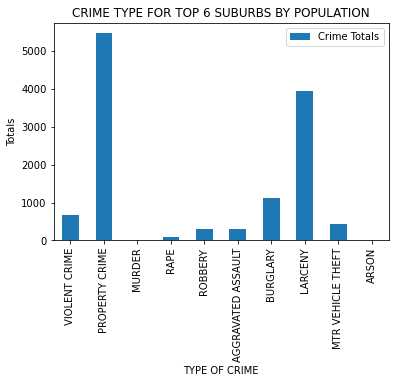

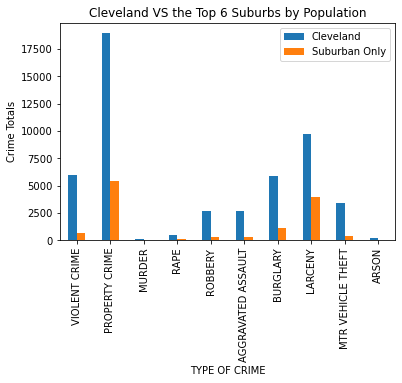

In [49]:

plotdata = pd.DataFrame({"Crime Totals":[680, 5469, 10, 89, 292, 289, 1111, 3936, 422, 14]},
                        index=["VIOLENT CRIME", "PROPERTY CRIME", "MURDER", "RAPE", "ROBBERY", 
                               "AGGRAVATED ASSAULT", "BURGLARY", "LARCENY", "MTR VEHICLE THEFT", "ARSON"])            
 

plotdata.reset_index().plot(x="index", y=["Crime Totals"], kind="bar")
plt.title("CRIME TYPE FOR TOP 6 SUBURBS BY POPULATION")
plt.xlabel("TYPE OF CRIME")
plt.ylabel("Totals")



plotdata = pd.DataFrame({"Suburban Only":[680, 5469, 10, 89, 292, 289, 1111, 3936, 422, 14], 
                        "Cleveland":[5999, 18944, 107, 497, 2697, 2698, 5853, 9696, 3395, 253]},
                        index=["VIOLENT CRIME", "PROPERTY CRIME", "MURDER", "RAPE", "ROBBERY", 
                               "AGGRAVATED ASSAULT", "BURGLARY", "LARCENY", "MTR VEHICLE THEFT", "ARSON"])            
 

plotdata.reset_index().plot(x="index", y=["Cleveland", "Suburban Only"], kind="bar")
plt.title("Cleveland VS the Top 6 Suburbs by Population")
plt.xlabel("TYPE OF CRIME")
plt.ylabel("Crime Totals")

Text(0, 0.5, 'Totals')

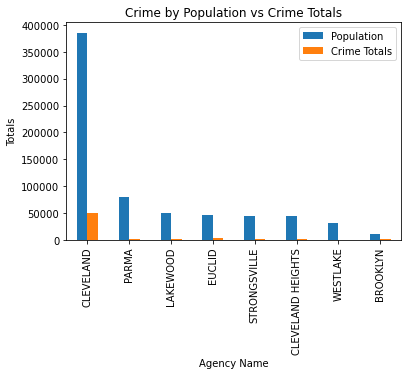

In [39]:
#Prep data for bar plot using population and violent crime. Top 7 cities by Population
#index_pop=["CLEVELAND", "PARMA", "LAKEWOOD", "EUCLID", "STRONGSVILLE", "CLEVELAND HEIGHTS", "WESTLAKE"]
#"index_crime"=["CLEVELAND", "PARMA", "LAKEWOOD", "EUCLID", "STRONGSVILLE", "CLEVELAND HEIGHTS", "WESTLAKE", "BROOKLYN"]
#"city_crime_total":[50139, 2096, 2551, 3146, 1740, 2021, 758, 1400]

plotdata = pd.DataFrame({"Population":[385351, 79340, 50151, 47270, 44758, 44525, 32330, 10809], 
                        "Crime Totals":[50139, 2096, 2551, 3146, 1740, 2021, 758, 1400]},
                        index=["CLEVELAND", "PARMA", "LAKEWOOD", "EUCLID", "STRONGSVILLE", "CLEVELAND HEIGHTS", "WESTLAKE", "BROOKLYN"])

plotdata.reset_index().plot(x="index", y=["Population", "Crime Totals"], kind="bar")
plt.title("Crime by Population vs Crime Totals")
plt.xlabel("Agency Name")
plt.ylabel("Totals")

Text(0, 0.5, 'Totals')

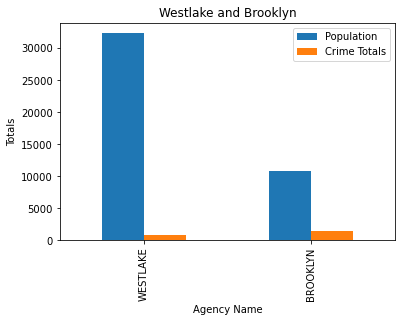

In [40]:
#Compare Westlake with Brooklyn.  Westlake=# 7 by Pop but low crime. Brooklyn=Top 7 by Crime Totals but lower population.

plotdata = pd.DataFrame({"Population":[32330, 10809], 
                        "Crime Totals":[758, 1400]},
                        index=["WESTLAKE", "BROOKLYN"])

plotdata.reset_index().plot(x="index", y=["Population", "Crime Totals"], kind="bar")
plt.title("Westlake and Brooklyn")
plt.xlabel("Agency Name")
plt.ylabel("Totals")


In [ ]:
asian=[]
black=[]
amer_ind=[]
white=[]
unknown=[]

In [ ]:
#Get Violent crime data for Cle 2017
url_race=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/violent-crime/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_race).json()

In [ ]:
#Get Asian count for violent crime in Cle
asian.append(response["data"][13]["value"])

In [ ]:
#Get Black or African American count for violent crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for violent crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for violent crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for violent crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get 2017 Property Crime data for Cle
url_property=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/property-crime/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_property).json()

In [ ]:
#Get Asian count for property crime in Cle 
asian.append(response["data"][13]["value"])

In [ ]:
#Get Black or African American count for property crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for property crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for property crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for property crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get 2017 Homicide data for Cle
url_homicide=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/homicide/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_homicide).json()

In [ ]:
#Get Asian count for homicide crime in Cle 
asian.append(response["data"][13]["value"])


In [ ]:
#Get Black or African American count for homicide crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for homicide crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for homicide crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for homicide crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Rape data for Cle 2017
url_rape=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/rape/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_rape).json()


In [ ]:
#Get Asian count for rape crime in Cle 
asian.append(response["data"][13]["value"])


In [ ]:
#Get Black or African American count for rape crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for rape crime in Cle
amer_ind.append(response["data"][58]["value"])


In [ ]:
#Get White count for rape crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for rape crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Robbery data for Cle 2017
url_robbery=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/robbery/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_robbery).json()

In [ ]:
#Get Asian count for robbery crime in Cle 
asian.append(response["data"][13]["value"])


In [ ]:
#Get Black or African American count for robbery crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for robbery crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for robbery crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for robbery crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Aggravated Assault data for Cle 2017
url_agg_assault=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/aggravated-assault/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_agg_assault).json()

In [ ]:
#Get Asian count for aggravated assault crime in Cle 
asian.append(response["data"][13]["value"])


In [ ]:
#Get Black or African American count for aggravated assault crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for aggravated assault crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for aggravated assault crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for aggravated assault crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Arson data for Cle 2017
url_arson=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/arson/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_arson).json()

In [ ]:
#Get Asian count for arson crime in Cle 
asian.append(response["data"][13]["value"])


In [ ]:
#Get Black or African American count for arson crime in Cle
black.append(response["data"][43]["value"])


In [ ]:
#Get American Indian count for arson crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for arson crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for arson crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Motor Vehicle Theft data for 2017
url_car=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/motor-vehicle-theft/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_car).json()

In [ ]:
#Get Asian count for motor-vehicle-theft crime in Cle 
asian.append(response["data"][13]["value"])


In [ ]:
#Get Black or African American count for motor-vehicle-theft crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for motor-vehicle-theft crime in Cle
amer_ind.append(response["data"][58]["value"])


In [ ]:
#Get White count for robbery motor-vehicle-theft in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for robbery motor-vehicle-theft in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Burlary data for Cle 2017
url_burglary=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/burglary/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_burglary).json()

In [ ]:
#Get Asian count for burglary crime in Cle 
asian.append(response["data"][13]["value"])

In [ ]:
#Get Black or African American count for burglary crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for burglary crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for burglary crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for burglary crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Get Larceny data for Cle 2017
url_larceny=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/larceny/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_larceny).json()

In [ ]:
#Get Asian count for larceny crime in Cle 
asian.append(response["data"][13]["value"])

In [ ]:
#Get Black or African American count for larceny crime in Cle
black.append(response["data"][43]["value"])

In [ ]:
#Get American Indian count for larceny crime in Cle
amer_ind.append(response["data"][58]["value"])

In [ ]:
#Get White count for larceny crime in Cle
white.append(response["data"][73]["value"])

In [ ]:
#Get Unknown count for larceny crime in Cle
unknown.append(response["data"][88]["value"])

In [ ]:
#Make crime list for Race DataFrame
crimes=["Violent Crime", "Property Crime", "Homicide", "Rape", "Robbery", "Aggravated Assault",
       "Arson", "Motor Vehicle Theft", "Burglary", "Larceny"]

In [ ]:
#Make Dataframe for Race Count
race_data= { "Crimes": crimes,
           "Asian Count": asian,
           "Black Count": black,
           "American Indian Count": amer_ind,
           "White Count": white,
           "Unknown Race": unknown}

race_data_df = pd.DataFrame(race_data)
race_data_df


In [ ]:
#Crimes by age pulling from api
url_agevc =f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/violent-crime/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agevc).json()
print(json.dumps(response, indent=4, sort_keys=True))

In [ ]:
#2017 violent crimes by age
vc_age0_9 = response["data"][13]["value"]
vc_age10_19 = response["data"][28]["value"]
vc_age20_29 = response["data"][43]["value"]
vc_age30_39 = response["data"][58]["value"]
vc_age40_49 = response["data"][73]["value"]
vc_age50_59 = response["data"][88]["value"]
vc_age60_69 = response["data"][103]["value"]
vc_age70_79 = response["data"][118]["value"]
vc_age80_89 = response["data"][133]["value"]
vc_age90_Older = response["data"][148]["value"]

vc_list = [vc_age0_9, vc_age10_19, vc_age20_29, vc_age30_39, vc_age40_49, vc_age50_59, vc_age60_69, vc_age70_79, vc_age80_89, vc_age90_Older]

In [ ]:
#2017 property crimes by age
url_agepc =f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/property-crime/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agepc).json()

pc_age0_9 = response["data"][13]["value"]
pc_age10_19 = response["data"][28]["value"]
pc_age20_29 = response["data"][43]["value"]
pc_age30_39 = response["data"][58]["value"]
pc_age40_49 = response["data"][73]["value"]
pc_age50_59 = response["data"][88]["value"]
pc_age60_69 = response["data"][103]["value"]
pc_age70_79 = response["data"][118]["value"]
pc_age80_89 = response["data"][133]["value"]
pc_age90_Older = response["data"][148]["value"]
pc_list = [pc_age0_9, pc_age10_19, pc_age20_29, pc_age30_39, pc_age40_49, pc_age50_59, pc_age60_69, pc_age70_79, pc_age80_89, pc_age90_Older]

In [ ]:
#2017 aggravated assault by age
url_ageaa = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/aggravated-assault/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_ageaa).json()

aa_age0_9 = response["data"][13]["value"]
aa_age10_19 = response["data"][28]["value"]
aa_age20_29 = response["data"][43]["value"]
aa_age30_39 = response["data"][58]["value"]
aa_age40_49 = response["data"][73]["value"]
aa_age50_59 = response["data"][88]["value"]
aa_age60_69 = response["data"][103]["value"]
aa_age70_79 = response["data"][118]["value"]
aa_age80_89 = response["data"][133]["value"]
aa_age90_Older = response["data"][148]["value"]
aa_list = [aa_age0_9, aa_age10_19, aa_age20_29, aa_age30_39, aa_age40_49, aa_age50_59, aa_age60_69, aa_age70_79, aa_age80_89, aa_age90_Older]

In [ ]:
#2017 burglary by age
url_ageburglary = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/burglary/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_ageburglary).json()
burglary_age0_9 = response["data"][13]["value"]
burglary_age10_19 = response["data"][28]["value"]
burglary_age20_29 = response["data"][43]["value"]
burglary_age30_39 = response["data"][58]["value"]
burglary_age40_49 = response["data"][73]["value"]
burglary_age50_59 = response["data"][88]["value"]
burglary_age60_69 = response["data"][103]["value"]
burglary_age70_79 = response["data"][118]["value"]
burglary_age80_89 = response["data"][133]["value"]
burglary_age90_Older = response["data"][148]["value"]
burglary_list = [burglary_age0_9, burglary_age10_19, burglary_age20_29, burglary_age30_39, burglary_age40_49, burglary_age50_59, burglary_age60_69, burglary_age70_79, burglary_age80_89, burglary_age90_Older]


In [ ]:
#2017 larceny by age
url_agelarceny = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/larceny/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agelarceny).json()
larceny_age0_9 = response["data"][13]["value"]
larceny_age10_19 = response["data"][28]["value"]
larceny_age20_29 = response["data"][43]["value"]
larceny_age30_39 = response["data"][58]["value"]
larceny_age40_49 = response["data"][73]["value"]
larceny_age50_59 = response["data"][88]["value"]
larceny_age60_69 = response["data"][103]["value"]
larceny_age70_79 = response["data"][118]["value"]
larceny_age80_89 = response["data"][133]["value"]
larceny_age90_Older = response["data"][148]["value"]
larceny_list = [larceny_age0_9, larceny_age10_19, larceny_age20_29, larceny_age30_39, larceny_age40_49, larceny_age50_59, larceny_age60_69, larceny_age70_79, larceny_age80_89, larceny_age90_Older]


In [ ]:
#2017 mvt by age
url_agemvt = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/motor-vehicle-theft/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agemvt).json()
mvt_age0_9 = response["data"][13]["value"]
mvt_age10_19 = response["data"][28]["value"]
mvt_age20_29 = response["data"][43]["value"]
mvt_age30_39 = response["data"][58]["value"]
mvt_age40_49 = response["data"][73]["value"]
mvt_age50_59 = response["data"][88]["value"]
mvt_age60_69 = response["data"][103]["value"]
mvt_age70_79 = response["data"][118]["value"]
mvt_age80_89 = response["data"][133]["value"]
mvt_age90_Older = response["data"][148]["value"]
mvt_list = [mvt_age0_9, mvt_age10_19, mvt_age20_29, mvt_age30_39, mvt_age40_49, mvt_age50_59, mvt_age60_69, mvt_age70_79, mvt_age80_89, mvt_age90_Older]

In [ ]:
#2017 homicide by age
url_agehomicide = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/homicide/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agehomicide).json()
homicide_age0_9 = response["data"][13]["value"]
homicide_age10_19 = response["data"][28]["value"]
homicide_age20_29 = response["data"][43]["value"]
homicide_age30_39 = response["data"][58]["value"]
homicide_age40_49 = response["data"][73]["value"]
homicide_age50_59 = response["data"][88]["value"]
homicide_age60_69 = response["data"][103]["value"]
homicide_age70_79 = response["data"][118]["value"]
homicide_age80_89 = response["data"][133]["value"]
homicide_age90_Older = response["data"][148]["value"]
homicide_list = [homicide_age0_9, homicide_age10_19, homicide_age20_29, homicide_age30_39, homicide_age40_49, homicide_age50_59, homicide_age60_69, homicide_age70_79, homicide_age80_89, homicide_age90_Older]

In [ ]:
#2017 rape by age
url_agerape = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/rape/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agerape).json()
rape_age0_9 = response["data"][13]["value"]
rape_age10_19 = response["data"][28]["value"]
rape_age20_29 = response["data"][43]["value"]
rape_age30_39 = response["data"][58]["value"]
rape_age40_49 = response["data"][73]["value"]
rape_age50_59 = response["data"][88]["value"]
rape_age60_69 = response["data"][103]["value"]
rape_age70_79 = response["data"][118]["value"]
rape_age80_89 = response["data"][133]["value"]
rape_age90_Older = response["data"][148]["value"]

rape_list = [rape_age0_9, rape_age10_19, rape_age20_29, rape_age30_39, rape_age40_49, rape_age50_59, rape_age60_69, rape_age70_79, rape_age80_89, rape_age90_Older]

In [ ]:
#2017 robbery by age
url_agerobbery = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/robbery/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agerobbery).json()
robbery_age0_9 = response["data"][13]["value"]
robbery_age10_19 = response["data"][28]["value"]
robbery_age20_29 = response["data"][43]["value"]
robbery_age30_39 = response["data"][58]["value"]
robbery_age40_49 = response["data"][73]["value"]
robbery_age50_59 = response["data"][88]["value"]
robbery_age60_69 = response["data"][103]["value"]
robbery_age70_79 = response["data"][118]["value"]
robbery_age80_89 = response["data"][133]["value"]
robbery_age90_Older = response["data"][148]["value"]
robbery_list = [robbery_age0_9, robbery_age10_19, robbery_age20_29, robbery_age30_39, robbery_age40_49, robbery_age50_59, robbery_age60_69, robbery_age70_79, robbery_age80_89, robbery_age90_Older]


In [ ]:
#2017 arson by age
url_agearson = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/arson/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agearson).json()
arson_age50_59 = response["data"][88]["value"]
arson_age60_69 = response["data"][103]["value"]
arson_age70_79 = response["data"][118]["value"]
arson_age0_9 = response["data"][13]["value"]
arson_age10_19 = response["data"][28]["value"]
arson_age20_29 = response["data"][43]["value"]
arson_age30_39 = response["data"][58]["value"]
arson_age40_49 = response["data"][73]["value"]
arson_age80_89 = response["data"][133]["value"]
arson_age90_Older = response["data"][148]["value"]
arson_list = [arson_age0_9, arson_age10_19, arson_age20_29, arson_age30_39, arson_age40_49, arson_age50_59, arson_age60_69, arson_age70_79, arson_age80_89, arson_age90_Older]


In [ ]:
#create dataframe for age data
age_list= ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-Older', 'unknown']
cle2017_crime_age_df = pd.DataFrame(list(zip(age_list, vc_list, pc_list, aa_list, burglary_list, larceny_list, mvt_list, homicide_list ,rape_list, robbery_list, arson_list)),columns=["Age Groups", "Violent-Crime", "Property-Crime", "Aggravated-Assault", "Burglary", "Larceny", "Motor-Vehicle-Theft", "Homicide", "Rape", "Robbery", "Arson"])
cle2017_crime_age_df


In [ ]:
# Change rows and columns to more easily develop graphs
Graph_race = pd.DataFrame.transpose(race_data_df)
Graph_race = Graph_race.drop(['Crimes'])
Graph_race

In [ ]:
# Creaate violent crime bar graph - Race
violent_crime = Graph_race.loc[:,0]

# Set x and y values
y_axis = [Graph_race.loc[:,0]]
x_axis = Graph_race.index

# Set ticks
ticks = 20, 200, 400, 1000, 1400, 1800, 2200, 2600, 3000, 3400, 3800, 4000
plt.yticks(ticks=ticks, labels=None)

# Set type
violent_crime.plot(kind='bar', facecolor='lightpink', figsize=(5,30
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Violent Crimes')
plt.title('Violent Crimes Committed per Race')
plt.show()

In [ ]:
# Creaate property crime bar graph - Race
property_crime = Graph_race.loc[:,1]

# Set x and y values
y_axis = [Graph_race.loc[:,1]]
x_axis = Graph_race.index

# Set ticks
ticks = 50, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
plt.yticks(ticks=ticks, labels=None)

# Set type
property_crime.plot(kind='bar', facecolor='lightpink', figsize=(5,30
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Property Crimes')
plt.title('Property Crimes Committed per Race')
plt.show()

In [ ]:
# Creaate homicide bar graph - Race
homicide_crime = Graph_race.loc[:,2]

# Set x and y values
y_axis = [Graph_race.loc[:,2]]
x_axis = Graph_race.index

# Set ticks
ticks = 20, 40, 60, 80
plt.yticks(ticks=ticks, labels=None)

# Set type
homicide_crime.plot(kind='bar', facecolor='lightpink', figsize=(10,5
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Homicides')
plt.title('Homicides Committed per Race')
plt.show()

In [ ]:
# Create rape bar graph - Race
Rape_crime = Graph_race.loc[:,3]

# Set x and y values
y_axis = [Graph_race.loc[:,3]]
x_axis = Graph_race.index

# Set ticks
ticks = 50, 100, 150, 200, 250, 300, 350, 400
plt.yticks(ticks=ticks, labels=None)

# Set type
Rape_crime.plot(kind='bar', facecolor='lightpink', figsize=(5,5
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Rapes')
plt.title('Rapes Committed per Race')
plt.show()

In [ ]:
# Create robbery bar graph - Race
Robbery_crime = Graph_race.loc[:,4]

# Set x and y values
y_axis = [Graph_race.loc[:,4]]
x_axis = Graph_race.index

# Set ticks
ticks = 100, 200, 300, 500, 1500, 2000, 2500
plt.yticks(ticks=ticks, labels=None)

# Set type
Robbery_crime.plot(kind='bar', facecolor='lightpink', figsize=(5,10
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Robberies')
plt.title('Robberies Committed per Race')
plt.show()

In [ ]:
# Create aggravated assault bar graph - Race
aggravated_assault = Graph_race.loc[:,5]

# Set x and y values
y_axis = [Graph_race.loc[:,5]]
x_axis = Graph_race.index

# Set ticks
ticks = 20, 200, 400, 600, 1200, 1500
plt.yticks(ticks=ticks, labels=None)

# Set type
aggravated_assault.plot(kind='bar', facecolor='lightpink', figsize=(5,10
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Aggravated Assaults')
plt.title('Aggravated Assaults Committed per Race')
plt.show()

In [ ]:
# Create arson bar graph - Race
arson = Graph_race.loc[:,6]

# Set x and y values
y_axis = [Graph_race.loc[:,6]]
x_axis = Graph_race.index

# Set ticks
ticks = 10, 20, 30, 40, 50
plt.yticks(ticks=ticks, labels=None)

# Set type
arson.plot(kind='bar', facecolor='lightpink', figsize=(5,10
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Arsons')
plt.title('Arsons Committed per Race')
plt.show()

In [ ]:
# Create motor vehicle theft bar graph - Race
mv_theft = Graph_race.loc[:,7]

# Set x and y values
y_axis = [Graph_race.loc[:,7]]
x_axis = Graph_race.index

# Set ticks
ticks = 50, 100, 150, 200, 250, 300, 350, 400, 450, 5000, 550, 600, 650
plt.yticks(ticks=ticks, labels=None)

# Set type
mv_theft.plot(kind='bar', facecolor='lightpink', figsize=(5,10
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Motor Vehicle Thefts')
plt.title('Motor Vehicle Thefts Committed per Race')
plt.show()

In [ ]:
# Create Burglary bar graph - Race
Burglary = Graph_race.loc[:,8]

# Set x and y values
y_axis = [Graph_race.loc[:,8]]
x_axis = Graph_race.index

# Set ticks
ticks = 50, 150, 300, 450, 600, 750, 900, 1050, 1300, 
plt.yticks(ticks=ticks, labels=None)

# Set type
Burglary.plot(kind='bar', facecolor='lightpink', figsize=(5,20
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Burglaries')
plt.title('Burglaries Committed per Race')
plt.show()

In [ ]:
# Create Larceny bar graph - Race
larceny = Graph_race.loc[:,9]

# Set x and y values
y_axis = [Graph_race.loc[:,9]]
x_axis = Graph_race.index

# Set ticks
ticks = 50, 150, 300, 450, 600, 750, 900, 1050, 1300, 1450, 1600, 1750, 1900, 2050, 2300, 2450, 2600, 2700, 2900
plt.yticks(ticks=ticks, labels=None)

# Set type
larceny.plot(kind='bar', facecolor='lightpink', figsize=(5,10
))

# Format
plt.xlabel('Race')
plt.ylabel('Number of Larceny Committed')
plt.title('Larceny Committed per Race')
plt.show()

In [ ]:
# Create bar graph for violent crime - age

# Axes
violent = [4, 21, 17, 11, 7, 9, 3, 1, 0, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]


# Graph Format
plt.bar(x_axis, violent, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Violent Crimes')
plt.title('Violent Crimes Committed per Age Group')
plt.xticks(rotation='vertical')


In [ ]:
# Create bar graph for property crime - age

# Axes
property = [58, 1025, 1823, 1315, 753, 553, 121, 13, 3, 3]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Set ticks
ticks = 50, 250, 450, 650, 850, 1050, 1250, 1450, 1650, 1850 
plt.yticks(ticks=ticks, labels=None)

# Graph Format
plt.bar(x_axis, property, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Property Crimes')
plt.title('Property Crimes Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for assault crime - age

# Axes
assault = [5, 189, 588, 358, 211, 154, 43, 9, 1, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, assault, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Aggravated Assaults')
plt.title('Aggravated Assaults Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for burglary crime - age

# Axes
burglary_age = [14, 263, 529, 348, 171, 125, 23, 3, 0, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, burglary_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Burglaries')
plt.title('Burglaries Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for larceny crime - age

# Axes
larceny_age = [39, 547, 1057, 797, 526, 381, 92, 8, 2, 3]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, burglary_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Larcenies')
plt.title('Larcenies Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for motor vehicle theft - age

# Axes
mvt_age = [1, 194, 220, 159, 49, 38, 3, 1, 1, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, mvt_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Motor Vehicle Thefts')
plt.title('Motor Vehicle Thefts per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for Homicide - age

# Axes
homicide_age = [0, 7, 21, 10, 7, 1, 2, 0, 0, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, homicide_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Homicides')
plt.title('Homicides Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for Rape - age

# Axes
rape_age = [14, 80, 118, 81, 53, 44, 13, 1, 1, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, rape_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Rapes')
plt.title('Rapes Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for Robbery - age

# Axes
robbery_age = [4, 500, 630, 231, 104, 79, 5, 3, 0, 2]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, robbery_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Robberies')
plt.title('Robberies Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Create bar graph for arson - age

# Axes
arson_age = [4, 21, 17, 11, 7, 9, 3, 1, 0, 0]
x_axis = cle2017_crime_age_df['Age Groups']
tick_locations = [value for value in x_axis]

# Graph Format
plt.bar(x_axis, arson_age, color='green', alpha=0.5, align="center")
plt.xlabel('Age Groups')
plt.ylabel('Number of Arsons')
plt.title('Arsons Committed per Age Group')
plt.xticks(rotation='vertical')

In [ ]:
# Enter Lat and Lng into list
lat = [41.49932, 41.484766, 41.39311, 41.405772, 41.366161, 41.319776, 41.313943, 41.439774, 41.429852, 41.520052, 41.533107, 41.593105, 41.441437, 41.416997, 41.517552, 41.361721, 41.551995, 41.368665, 41.481993, 41.501344, 41.519219, 41.451142, 41.415603, 41.313664, 41.377325, 41.375049, 41.404774, 41.390052, 41.478387, 41.552829, 41.47305, 41.382078, 41.389776, 41.523108, 41.314497, 41.497831, 41.387831, 41.352225, 41.448387, 41.455323, 41.462276, 41.4451]
lng = [-81.694361, -81.922084, -81.536509, -81.498117, -81.854303, -81.62679, -81.685127, -81.73541, -81.3911,  -81.556235, -81.579014, -81.526787, -81.864304, -81.605958, -81.403448, -81.46956, -81.478452, -81.637903, -81.798191,  -81.503097, -81.457896, -81.409714, -81.923473, -81.724574,  -81.944215, -81.908194, -81.722909, -81.759577, -81.46373, -81.510121, -81.854261,  -81.662834, -81.441226, -81.518455, -81.83569, -81.537346, -81.604569, -81.545527, -81.51901,  -81.917917, -81.480675, -81.766523]

# Create Columns in cuy_data
cuy_data['LAT'] = lat
cuy_data['LNG'] = lng

# Confirm columns are addeda and correct
cuy_data.head()


In [ ]:
# Heat map for crimes/population per city - weight for the map
pop_crime_tot = cuy_data['TOTALS']

# Configure gmaps
gmaps.configure(api_key=g_key)

# Store latitude and longitude in locations
locations = cuy_data[["LAT", "LNG"]]

In [ ]:
# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = pop_crime_tot, dissipating=True, max_intensity=300, point_radius=15)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

In [ ]:
# Heat map for crimes/population per city - weight for the map
pop_crime = cuy_data['POPULATION']/cuy_data['TOTALS']

# Configure gmaps
gmaps.configure(api_key=g_key)

# Store latitude and longitude in locations
locations = cuy_data[["LAT", "LNG"]]


In [ ]:
# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = pop_crime, dissipating=True, max_intensity=300, point_radius=32.75)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig